<a href="https://colab.research.google.com/github/dwdb/tensorflow2.0-tutorial/blob/master/classification_on_imbalance_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras

mpl.rcParams['figure.figsize'] = (15, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
# dataset processing
df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')

# You don't want the `Time` column.
df.pop('Time')

# The `Amount` column covers a huge range. Convert to log-space.
eps = 0.001 # 0 => 0.1¢
df['Amount'] = np.log(df.pop('Amount') + eps)

(neg, pos), total = np.bincount(df['Class']), df.shape[0]
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))

y = df.pop('Class').values
x = df.values
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2)

# standard normalization
scaler = StandardScaler()
train_x = np.clip(scaler.fit_transform(train_x), -5, 5)
test_x = np.clip(scaler.transform(test_x), -5, 5)

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



In [0]:
metrics = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc')
]

BATCH_SIZE = 2048
BUFFER_SIZE = 100000
EPOCHS = 20

model = keras.Sequential([
    keras.layers.Dense(16, activation='relu', input_shape=(train_x.shape[-1], )),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True
)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=metrics
)

initial_weights = model.get_weights()

In [4]:
print('Training Zero Bias Model')
model.set_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_x, 
    train_y, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    validation_data=(test_x, test_y), 
    verbose=1,
    callbacks=[early_stopping],
)
zero_preditions = model.predict(test_x, batch_size=2048)

Training Zero Bias Model
Epoch 1/20
112/112 [==============================] - 2s 14ms/step - loss: 0.3740 - tp: 101.0000 - fp: 34812.0000 - tn: 192644.0000 - fn: 288.0000 - accuracy: 0.8459 - precision: 0.0029 - recall: 0.2596 - auc: 0.4523 - val_loss: 0.1339 - val_tp: 14.0000 - val_fp: 7.0000 - val_tn: 56852.0000 - val_fn: 89.0000 - val_accuracy: 0.9983 - val_precision: 0.6667 - val_recall: 0.1359 - val_auc: 0.4574
Epoch 2/20
112/112 [==============================] - 1s 8ms/step - loss: 0.1652 - tp: 104.0000 - fp: 7082.0000 - tn: 220374.0000 - fn: 285.0000 - accuracy: 0.9677 - precision: 0.0145 - recall: 0.2674 - auc: 0.5701 - val_loss: 0.0503 - val_tp: 20.0000 - val_fp: 5.0000 - val_tn: 56854.0000 - val_fn: 83.0000 - val_accuracy: 0.9985 - val_precision: 0.8000 - val_recall: 0.1942 - val_auc: 0.7203
Epoch 3/20
112/112 [==============================] - 1s 8ms/step - loss: 0.1011 - tp: 125.0000 - fp: 2458.0000 - tn: 224998.0000 - fn: 264.0000 - accuracy: 0.9881 - precision: 0.0484 -

In [5]:
print('Training Care Bias Model')
model.set_weights(initial_weights)
model.layers[-1].bias.assign([np.log(pos/neg, dtype=np.float32)])
care_bias_history = model.fit(
    train_x, 
    train_y, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    validation_data=(test_x, test_y), 
    verbose=1,
    callbacks=[early_stopping],
)
care_preditions = model.predict(test_x, batch_size=2048)

Training Care Bias Model
Epoch 1/20
112/112 [==============================] - 1s 8ms/step - loss: 0.0101 - tp: 93.0000 - fp: 26.0000 - tn: 227430.0000 - fn: 296.0000 - accuracy: 0.9986 - precision: 0.7815 - recall: 0.2391 - auc: 0.7613 - val_loss: 0.0055 - val_tp: 50.0000 - val_fp: 11.0000 - val_tn: 56848.0000 - val_fn: 53.0000 - val_accuracy: 0.9989 - val_precision: 0.8197 - val_recall: 0.4854 - val_auc: 0.9161
Epoch 2/20
112/112 [==============================] - 1s 7ms/step - loss: 0.0074 - tp: 151.0000 - fp: 30.0000 - tn: 227426.0000 - fn: 238.0000 - accuracy: 0.9988 - precision: 0.8343 - recall: 0.3882 - auc: 0.8645 - val_loss: 0.0048 - val_tp: 60.0000 - val_fp: 12.0000 - val_tn: 56847.0000 - val_fn: 43.0000 - val_accuracy: 0.9990 - val_precision: 0.8333 - val_recall: 0.5825 - val_auc: 0.9362
Epoch 3/20
112/112 [==============================] - 1s 8ms/step - loss: 0.0071 - tp: 177.0000 - fp: 31.0000 - tn: 227425.0000 - fn: 212.0000 - accuracy: 0.9989 - precision: 0.8510 - recall

In [6]:
print('Training Weighted Model')
weight_for_0 = total / neg / 2.0
weight_for_1 = total / pos / 2.0
class_weight = {0: weight_for_0, 1: weight_for_1}

model.set_weights(initial_weights)
weighted_history = model.fit(
    train_x, 
    train_y, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    validation_data=(test_x, test_y), 
    verbose=1,
    callbacks=[early_stopping],
    class_weight=class_weight,
)
weighted_preditions = model.predict(test_x, batch_size=2048)

Training Weighted Model
Epoch 1/20
112/112 [==============================] - 1s 7ms/step - loss: 0.4451 - tp: 310.0000 - fp: 47670.0000 - tn: 179786.0000 - fn: 79.0000 - accuracy: 0.7904 - precision: 0.0065 - recall: 0.7969 - auc: 0.8688 - val_loss: 0.2731 - val_tp: 96.0000 - val_fp: 1853.0000 - val_tn: 55006.0000 - val_fn: 7.0000 - val_accuracy: 0.9673 - val_precision: 0.0493 - val_recall: 0.9320 - val_auc: 0.9746
Epoch 2/20
112/112 [==============================] - 1s 8ms/step - loss: 0.2695 - tp: 333.0000 - fp: 14991.0000 - tn: 212465.0000 - fn: 56.0000 - accuracy: 0.9340 - precision: 0.0217 - recall: 0.8560 - auc: 0.9450 - val_loss: 0.2093 - val_tp: 97.0000 - val_fp: 1364.0000 - val_tn: 55495.0000 - val_fn: 6.0000 - val_accuracy: 0.9759 - val_precision: 0.0664 - val_recall: 0.9417 - val_auc: 0.9800
Epoch 3/20
112/112 [==============================] - 1s 7ms/step - loss: 0.2543 - tp: 333.0000 - fp: 11460.0000 - tn: 215996.0000 - fn: 56.0000 - accuracy: 0.9495 - precision: 0.0282 

In [7]:
print('Training Oversampling Model')
train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y))
# filter is so slowly
# pos_ds = train_ds.filter(lambda x,y: y == 1).shuffle(100000).repeat()
# neg_ds = train_ds.filter(lambda x,y: y == 0).shuffle(100000).repeat()

pos_indices = train_y == 1
pos_x, neg_x = train_x[pos_indices], train_x[~pos_indices]
pos_y, neg_y = train_y[pos_indices], train_y[~pos_indices]
pos_ds = tf.data.Dataset.from_tensor_slices((pos_x, pos_y)).shuffle(BUFFER_SIZE).repeat()
neg_ds = tf.data.Dataset.from_tensor_slices((neg_x, neg_y)).shuffle(BUFFER_SIZE).repeat()
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)

test_ds = tf.data.Dataset.from_tensor_slices((test_x, test_y)).cache()
test_ds = test_ds.batch(BATCH_SIZE).prefetch(2) 

model.set_weights(initial_weights)
oversampling_history = model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    validation_data=test_ds,
    verbose=1,
    callbacks=[early_stopping]
)
oversampling_preditions = model.predict(test_x, batch_size=BATCH_SIZE)

Training Oversampling Model
Epoch 1/20
278/278 [==============================] - 5s 20ms/step - loss: 0.3727 - tp: 236252.0000 - fp: 48162.0000 - tn: 236837.0000 - fn: 48093.0000 - accuracy: 0.8309 - precision: 0.8307 - recall: 0.8309 - auc: 0.9066 - val_loss: 0.2339 - val_tp: 97.0000 - val_fp: 1436.0000 - val_tn: 55423.0000 - val_fn: 6.0000 - val_accuracy: 0.9747 - val_precision: 0.0633 - val_recall: 0.9417 - val_auc: 0.9793
Epoch 2/20
278/278 [==============================] - 5s 17ms/step - loss: 0.2368 - tp: 247769.0000 - fp: 14598.0000 - tn: 270305.0000 - fn: 36672.0000 - accuracy: 0.9099 - precision: 0.9444 - recall: 0.8711 - auc: 0.9596 - val_loss: 0.1650 - val_tp: 98.0000 - val_fp: 1291.0000 - val_tn: 55568.0000 - val_fn: 5.0000 - val_accuracy: 0.9772 - val_precision: 0.0706 - val_recall: 0.9515 - val_auc: 0.9829
Epoch 3/20
278/278 [==============================] - 5s 17ms/step - loss: 0.1999 - tp: 251226.0000 - fp: 10972.0000 - tn: 274215.0000 - fn: 32931.0000 - accuracy: 0.

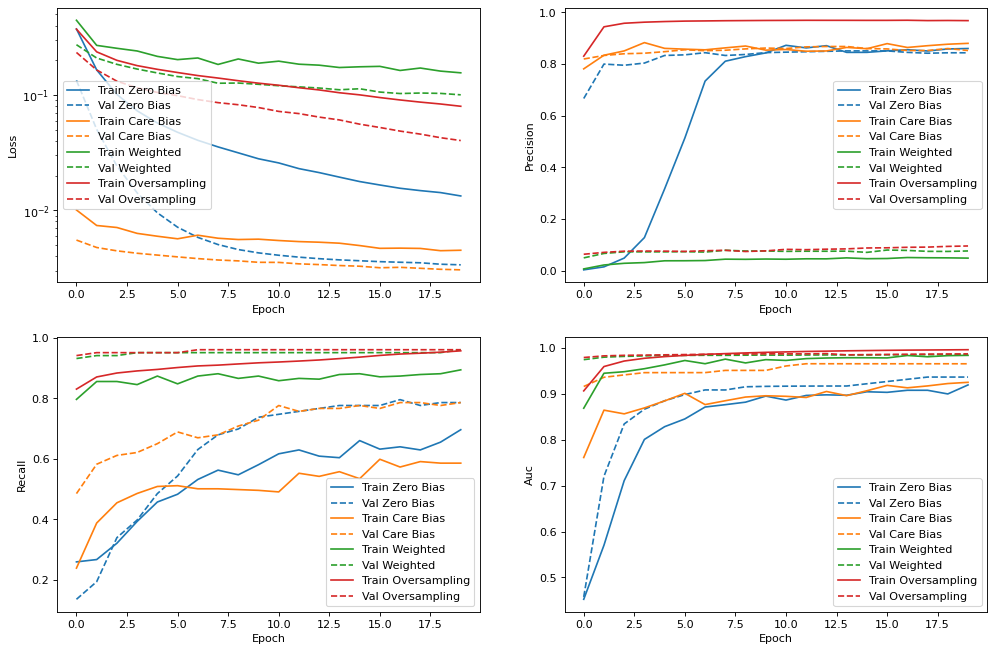

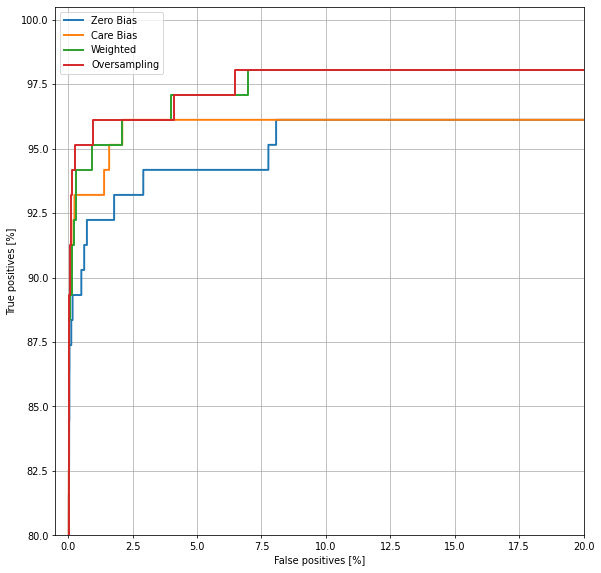

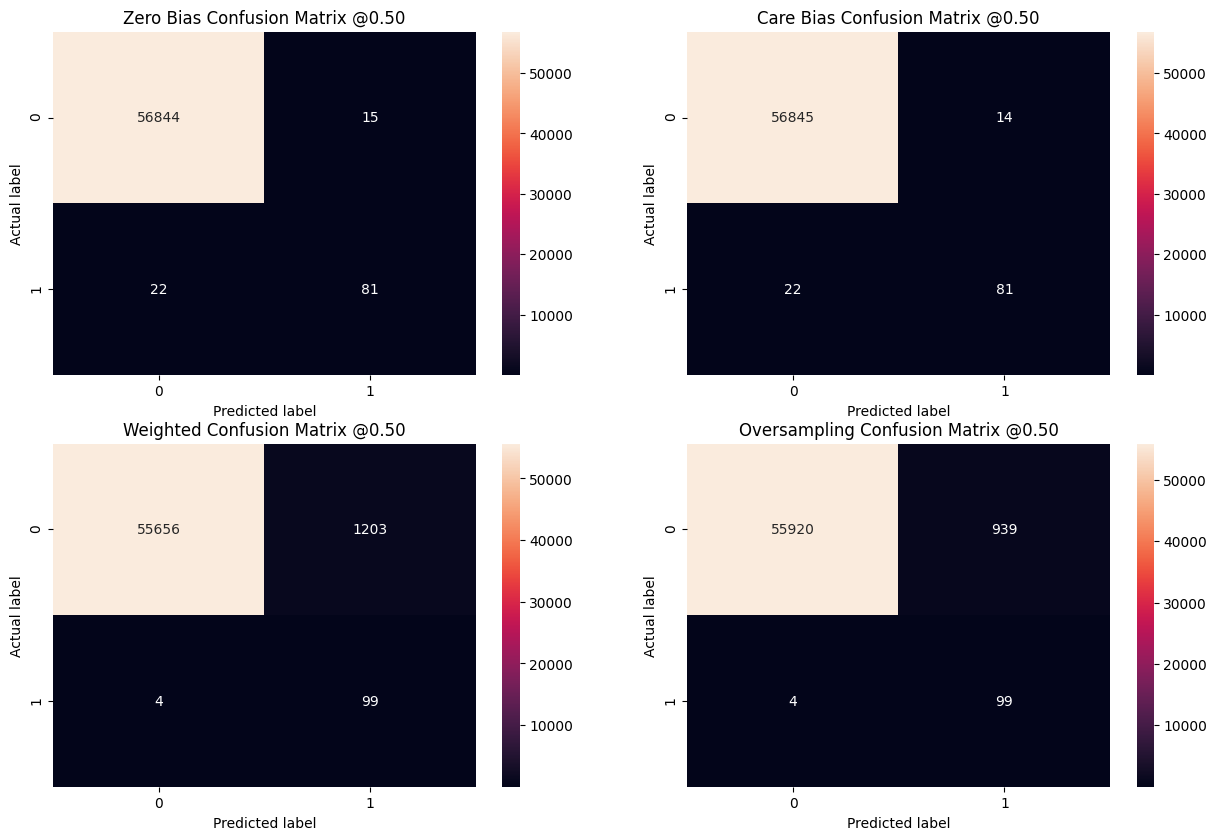

In [17]:
def plot_metrics(histories, targets, predictions, labels, p=0.5):
  """打印训练过程和预测结果"""
  # evaluation index
  plt.figure(dpi=80)
  for i, metric in enumerate(['loss', 'precision', 'recall', 'auc']):
    plt.subplot(2,2,i+1)
    for n, history in enumerate(histories):
      f_plot = plt.semilogy if metric == 'loss' else plt.plot
      f_plot(history.epoch,  history.history[metric], color=colors[n], label='Train ' + labels[n])
      f_plot(history.epoch,  history.history['val_' + metric], color=colors[n], label='Val '+labels[n], linestyle="--")
      plt.xlabel('Epoch')
      plt.ylabel(metric.capitalize())
      plt.legend()

  # roc curve
  plt.figure(dpi=70)
  for i, (target, prediction) in enumerate(zip(targets, predictions)):
    fp, tp, _ = sklearn.metrics.roc_curve(target, prediction)
    plt.plot(100*fp, 100*tp, label=labels[i], linewidth=2, color=colors[i])
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.legend()
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

  # confusion matrix
  plt.figure(dpi=100)
  for i, (target, prediction) in enumerate(zip(targets, predictions)):
    plt.subplot(2, 2, i+1)
    cm = confusion_matrix(target, prediction > p)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(labels[i] + ' Confusion Matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')


plot_metrics(
    histories=[zero_bias_history, care_bias_history, weighted_history, oversampling_history], 
    targets=[test_y, test_y, test_y, test_y], 
    predictions=[zero_preditions, care_preditions, weighted_preditions, oversampling_preditions], 
    labels=['Zero Bias', 'Care Bias', 'Weighted', 'Oversampling']
)


In [9]:
zero_preditions

array([[1.4060179e-05],
       [4.3519699e-06],
       [1.4096255e-05],
       ...,
       [1.2670596e-06],
       [2.7037925e-06],
       [1.8053996e-06]], dtype=float32)

In [10]:
colors

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']